<a href="https://colab.research.google.com/github/LouisVanLangendonck/UPC-AML-ArchitectureClassif/blob/main/Binary_CNN_pretrained_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
unpack_data = True

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
import random
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("keras version:", keras.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
keras version: 2.9.0
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
if unpack_data:
    drive_path = 'drive/MyDrive/FIB-2022-2023/aml/data/binary_data.zip'
    local_path = '/content'

    !cp '{drive_path}' .

    os.chdir(local_path)
    !unzip -q 'binary_data.zip'

replace bin_test/noucentisme/noucentisme-10-0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bin_test/noucentisme/noucentisme-1004-0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bin_test/noucentisme/noucentisme-1004-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bin_test/noucentisme/noucentisme-1004-2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bin_test/noucentisme/noucentisme-1004-3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_data = '/content/bin_train'
val_data = '/content/bin_val'
test_data = '/content/bin_test'
print(os.listdir(train_data))

['noucentisme', 'romanesque']


The convolutional base I will be using is EfficientNet

In [ ]:
from tensorflow.keras.applications import VGG16
from keras import layers
from keras import models

conv_base = VGG16(
    weights='imagenet',
    include_top=False
)

58889256/58889256 [==============================] - 0s 0us/step


Using simple pretrained feature extraction followed by a dense fully connected NN:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator = datagen.flow_from_directory(
        train_data, 
        target_size = (224,224),
        batch_size=batch_size, 
        class_mode = 'binary')

val_generator = datagen.flow_from_directory(
        val_data, 
        target_size = (224,224),
        batch_size=batch_size, 
        class_mode = 'binary')

test_generator = datagen.flow_from_directory(
        test_data, 
        target_size = (224,224),
        batch_size=batch_size, 
        class_mode = 'binary')

Found 4027 images belonging to 2 classes.
Found 1328 images belonging to 2 classes.
Found 1339 images belonging to 2 classes.


In [ ]:
train_images = 4027
val_images = 1328
test_images = 1339

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def extract_features(generator, sample_count):
    features = np.zeros(shape = (sample_count,7,7,512))
    labels = np.zeros(shape = (sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if (i+1)*batch_size >= sample_count:
            features[i*batch_size:sample_count] = features_batch[0:sample_count-i*batch_size]
            labels[i*batch_size:sample_count] = labels_batch[0:sample_count-i*batch_size]
            break
    print('Features extracted!')
    print('Shape of feature vector:{}'.format(features.shape))
    print('Shape of labels vector:{}'.format(labels.shape))
    return features, labels

print('Train Feature Extraction:')
train_features, train_labels = extract_features(train_generator, train_images)
print('Validation Feature Extraction:')
val_features, val_labels = extract_features(val_generator, val_images)
print('Test Feature Extraction:')
test_features, test_labels = extract_features(test_generator, test_images)

Train Feature Extraction:
Features extracted!
Shape of feature vector:(4027, 7, 7, 512)
Shape of labels vector:(4027,)
Validation Feature Extraction:
Features extracted!
Shape of feature vector:(1328, 7, 7, 512)
Shape of labels vector:(1328,)
Test Feature Extraction:
Features extracted!
Shape of feature vector:(1339, 7, 7, 512)
Shape of labels vector:(1339,)


In [ ]:
train_features = np.reshape(train_features, (train_images, 7*7*train_images))
val_features = np.reshape(val_features, (val_images, 7*7*val_images))
test_features = np.reshape(test_features, (test_images, 7*7*test_images))

In [ ]:
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7*7*train_images))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units = 1, activation='sigmoid'))
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels, 
                    epochs=30, 
                    batch_size=5, 
                    validation_data = (val_features, val_labels))

model.save('drive/MyDrive/FIB-2022-2023/aml/models/CNN_VGC_16_feat_extract_v1')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 513       
                                                                 
Total params: 12,846,081
Trainable params: 12,846,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
806/806 [==============================] - 5s 6ms/step - loss: 0.3115 - acc: 0.8686 - val_loss: 0.3098 - val_acc: 0.8622
Epoch 2/30
806/806 [==============================] - 4s 5ms/step - loss: 0.1928 - acc: 0.9255 - val_loss: 0.2380 - val_acc: 0.8938
Epoch 3/30
806/806 [======================

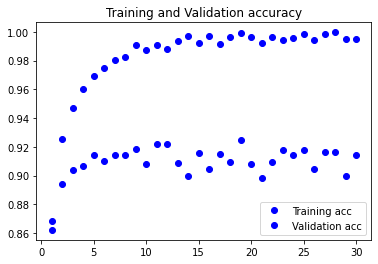

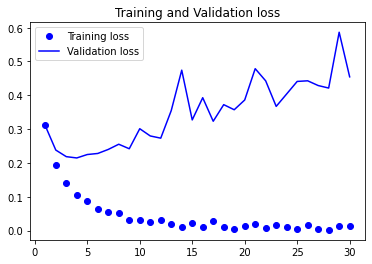

In [ ]:
import matplotlib.pyplot as plot

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'bo', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

About 90% accuracy!!

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range = 0.2,
#                                   zoom_range = 0.2,
#                                   horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     train_data, 
#     target_size = (300, 300),
#     batch_size = 32,
#     class_mode='binary')

# validation_generator = test_datagen.flow_from_directory(
#     val_data, 
#     target_size = (300, 300),
#     batch_size = 32,
#     class_mode='binary')

#Loads in image path

# style = 'romanesque' #style = 'noucentisme'
# random_train_img = os.path.join('/content/bin_train/{}'.format(style), os.listdir('/content/bin_train/{}'.format(style))[random.randint(0, 100)])
# img = keras.utils.load_img(random_train_img, target_size= (300,300))
# img_tensor = keras.utils.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)
# #Uses ImageDataGenerator to flip the images
# datagen = ImageDataGenerator(rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range = 0.2,
#                                   zoom_range = 0.2,
#                                   horizontal_flip=True)
# #Creates our batch of one image
# pic = datagen.flow(img_tensor, batch_size =1)
# plt.figure(figsize=(10,8))
# #Plots our figures
# for i in range(1,4):
#   plt.subplot(1, 3, i)
#   batch = pic.next()
#   image_ = batch[0].astype('uint8')
#   plt.imshow(image_)
# plt.show()

Found 4027 images belonging to 2 classes.
Found 1328 images belonging to 2 classes.


In [ ]:
# nr_of_batches_per_epoch = int(np.ceil(4027 / 32))
# print(nr_of_batches_per_epoch)
# nr_of_val_batches_per_epoch = int(np.ceil(1328 / 32))
# print(nr_of_val_batches_per_epoch)

126
42


In [ ]:
# checkpoint_path = "/content/binary_CNN_efficientNet_pretrained_v0/cp.ckpt"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=126)

In [ ]:
# from tensorflow.keras.applications import EfficientNetB3
# from keras import layers
# from keras import models

# efficient_net = EfficientNetB3(
#     weights='imagenet',
#     include_top=True,
#     pooling='max'
# )

# # efficient_net.trainable = False
# # for idx, layer in enumerate(efficient_net.layers[-20:]):
# #   if not isinstance(layer, layers.BatchNormalization):
# #             efficient_net.layers[idx].trainable = True

# model = models.Sequential()
# model.add(efficient_net)
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(units = 1, activation='sigmoid'))
# model.summary()

50095040/50095040 [==============================] - 2s 0us/step
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1000)             12320535  
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_39 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 12,321,536
Trainable params: 12,234,233
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True


# history = model.fit(
#         train_generator, 
#         steps_per_epoch=nr_of_batches_per_epoch, 
#         epochs=20,
#         validation_data=validation_generator, 
#         validation_steps=nr_of_val_batches_per_epoch,
#         callbacks= [cp_callback])

# model.save('binary_CNN-efficientNet_pretrained_v1')

Epoch 1/20
 38/126 [========>.....................] - ETA: 3:06 - loss: 0.6687 - accuracy: 0.7911
Epoch 1: saving model to /content/binary_CNN_efficientNet_pretrained_v0/cp.ckpt
126/126 [==============================] - 345s 3s/step - loss: 0.6590 - accuracy: 0.7512 - val_loss: 0.6918 - val_accuracy: 0.5331
Epoch 2/20
 38/126 [========>.....................] - ETA: 3:04 - loss: 0.6363 - accuracy: 0.7459
Epoch 2: saving model to /content/binary_CNN_efficientNet_pretrained_v0/cp.ckpt
126/126 [==============================] - 319s 3s/step - loss: 0.6288 - accuracy: 0.7450 - val_loss: 0.7084 - val_accuracy: 0.4669
Epoch 3/20
 38/126 [========>.....................] - ETA: 2:58 - loss: 0.6188 - accuracy: 0.7275
Epoch 3: saving model to /content/binary_CNN_efficientNet_pretrained_v0/cp.ckpt
126/126 [==============================] - 322s 3s/step - loss: 0.5926 - accuracy: 0.7591 - val_loss: 0.6966 - val_accuracy: 0.5331
Epoch 4/20
 38/126 [========>.....................] - ETA: 3:08 - loss